In [2]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import dill as pickle

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
<ipython-input-2-06da3225ef62>:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Dataset

## Mobility

In [3]:
mobility_data = pd.read_csv(
    "./Data/Google/Global_Mobility_Report.csv", 
    encoding="ISO-8859-1", 
    parse_dates=["date"],
    dayfirst=True
)
mobility_data_us = mobility_data[
    (mobility_data["country_region"]=="United States") & 
    (~mobility_data["sub_region_1"].isnull()) &
    (mobility_data["sub_region_2"].isnull())
]
mobility_data_us_temp = mobility_data_us.iloc[:,7:] # keep only relevant columns
mobility_data_us_temp["state"] = mobility_data_us["sub_region_1"]
mobility_data_us_temp.iloc[:,1:-1] = mobility_data_us_temp.iloc[:,1:-1].apply(lambda x: x/100 + 1)
mobility_data_us =  mobility_data_us_temp.reset_index(drop=True)
mobility_data_us = pd.DataFrame({
    "state": mobility_data_us["state"],
    "date": mobility_data_us["date"],
    "HOME": mobility_data_us['residential_percent_change_from_baseline'],
    "WORK": mobility_data_us['workplaces_percent_change_from_baseline'],
    "RECREATIONAL": mobility_data_us['retail_and_recreation_percent_change_from_baseline'],
    "OTHER": mobility_data_us.iloc[:,2:5].mean(axis=1)
})

processed_dfs = []

for state in mobility_data_us["state"].unique():
    d = mobility_data_us[mobility_data_us["state"] == state].copy()
    
    d["HOME"] = d["HOME"].rolling(7).median()
    d["WORK"] = d["WORK"].rolling(7).median()
    d["RECREATIONAL"] = d["RECREATIONAL"].rolling(7).median()
    d["OTHER"] = d["OTHER"].rolling(7).median()

    processed_dfs.append(d)
    
mobility_data_us = pd.concat(processed_dfs)

/Users/leo/.pyenv/versions/3.8.7/envs/covid/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Cases

In [4]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv(
    "./Data/Microsoft/COVID_CASES.csv", 
    encoding="ISO-8859-1",
    parse_dates=["Updated"],
    dayfirst=False
)
ms_us_covid = ms_covid[
    (ms_covid["Country_Region"]=="United States") & 
    (~ms_covid["AdminRegion1"].isnull()) &
    (ms_covid["AdminRegion2"].isnull())
]
ms_us_covid = ms_us_covid.loc[:,["AdminRegion1", "Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]
ms_us_covid.rename(columns={"AdminRegion1": "state"}, inplace=True)
ms_us_covid.reset_index(drop=True, inplace=True)
population = pd.read_excel(
    "./Data/Population/US_population_raw_data.xls",
)
STATE_POPULATION = dict(zip(population[1:].Location, population[1:].COVIDTotal))

processed_dfs = []

for state in ms_us_covid["state"].unique():
    d = ms_us_covid[ms_us_covid["state"] == state]
    d = d.fillna(method='ffill').fillna(0)
    d["I"] = d["Confirmed"] - d["Deaths"] - d["Recovered"]

    d["S"] = int(STATE_POPULATION[state]) - d["I"]

    d["ConfirmedChange"] = np.log(d["ConfirmedChange"].rolling(7).median()+1)
    d["I"] = np.log(d["I"].rolling(7).median()+1)
    d["S"] = np.log(d["S"].rolling(7).median()+1)

    d.dropna(inplace=True)
    processed_dfs.append(d)
    
ms_us_covid = pd.concat(processed_dfs)
ms_us_covid["WEEKDAY"] = (ms_us_covid["Updated"].dt.dayofweek < 5).astype(int)
ms_us_covid["index"] = ms_us_covid["Updated"].dt.dayofyear

## Merge

In [5]:
final_data = ms_us_covid.merge(
    mobility_data_us, how='left', left_on=["state", "Updated"], right_on=["state", "date"]
)
final_data.dropna(inplace=True)
final_data.set_index("state", inplace=True)

In [6]:
final_data.to_pickle("tmp/final_data.pkl")

# Model

In [7]:
times = None
for s in final_data.index.unique():
    s_times = set(final_data.loc[s, 'Updated'].unique())
    if times is None:
        times = s_times
    else:
        times = times.intersection(s_times)

In [8]:
def run_for_state(name, data):
    data = data.copy()
    data.reset_index(inplace=True, drop=True)
    t = data[["Updated"]]
    y = data[["ConfirmedChange"]]
    X = pd.DataFrame({
        "index": data["index"],
        "S": data["S"],
        "I": data["I"],
        "HOME": data["HOME"],
        "WORK": data["WORK"],
        "RECREATIONAL": data["RECREATIONAL"],
    }, index=data.index)[[
        "index",
        "S",
        "I",
        "HOME", 
        "WORK", 
        "RECREATIONAL"
    ]]

    model_params = {
        'kernel': (
            gpflow.kernels.SquaredExponential(lengthscales=np.ones(X.shape[1])) +
            gpflow.kernels.Linear() +
            gpflow.kernels.RationalQuadratic(lengthscales=np.ones(X.shape[1]))
        )
    }

    y_scaler = preprocessing.StandardScaler().fit(y)
    y_train = y_scaler.transform(y)

    x_scaler = preprocessing.StandardScaler().fit(X)
    X_train = x_scaler.transform(X)

    model = gpflow.models.VGP(
        data = (X_train, y_train),
        likelihood=gpflow.likelihoods.Gaussian(),
        **model_params
    )

    set_trainable(model.q_mu, False)
    set_trainable(model.q_sqrt, False)
    
    variational_optimizer = gpflow.optimizers.NaturalGradient(gamma=1.0)
    model_variables_optimizer = tf.optimizers.Adam(0.01)
    
    objective_closure = model.training_loss_closure()
    
    elbo = []
    for _ in range(gpflow.ci_utils.ci_niter(1000)):
        model_variables_optimizer.minimize(
            objective_closure,
            model.trainable_variables
        )
        variational_optimizer.minimize(
            objective_closure,
            [(model.q_mu, model.q_sqrt)]
        )
        elbo.append(model.elbo())

    mean_train, var_train = model.predict_y(X_train)
    y_train_pred = y_scaler.inverse_transform(mean_train.numpy())
    y_train_true = y_scaler.inverse_transform(y_train)

    res = y_train_true - y_train_pred
    
    return model, res

In [9]:
results_states = {}

final_data_ = final_data[final_data['Updated'].isin(times)]

for state in final_data_.index.unique():
    data = final_data_.loc[state]
    results_states[state] = run_for_state(state, data)

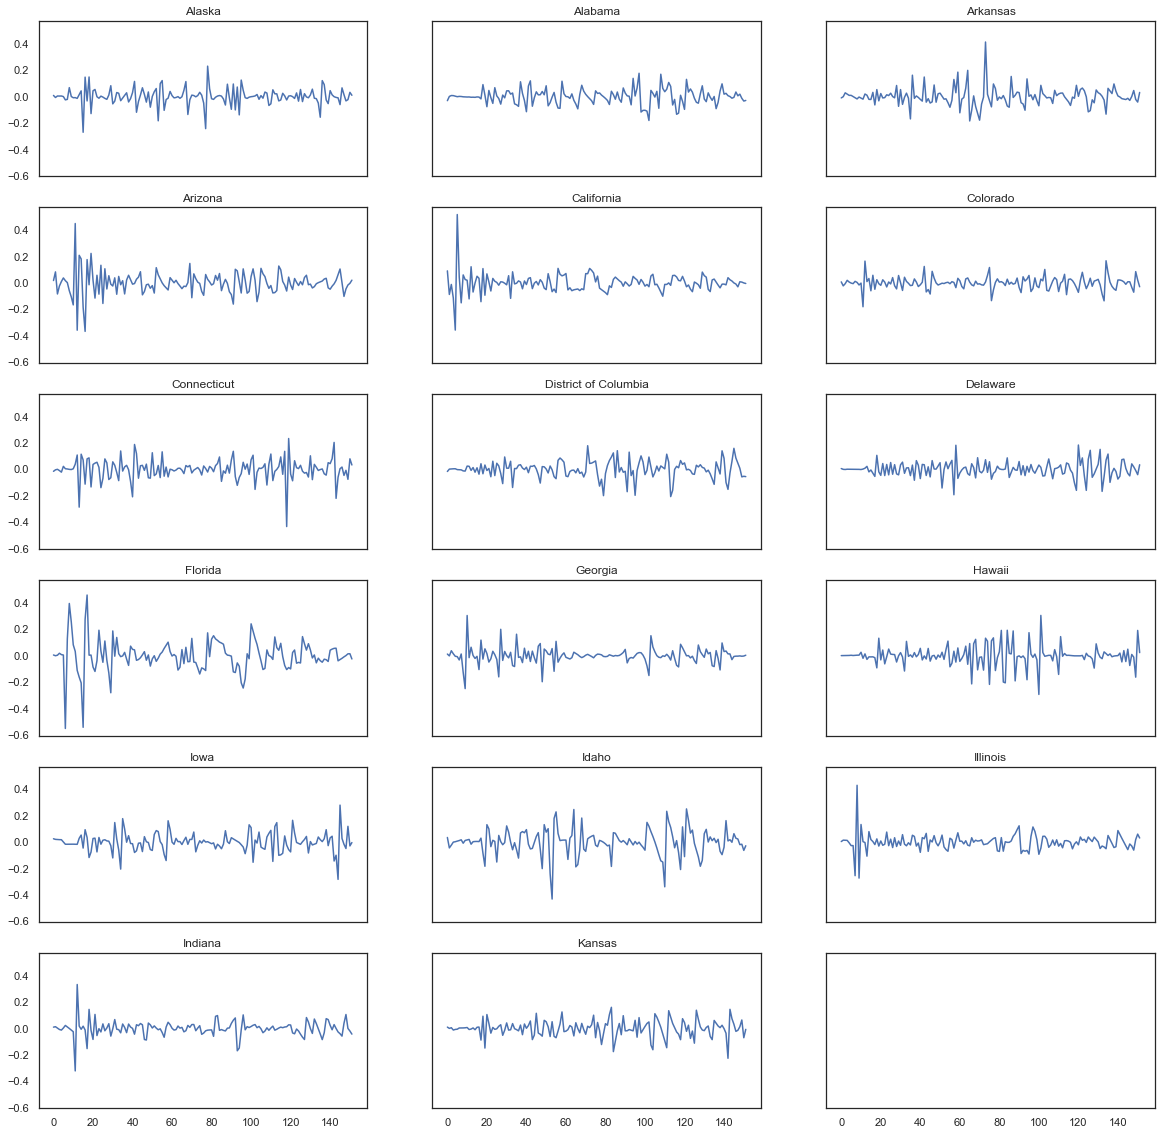

In [10]:
N = len(results_states)
fig, axs = plt.subplots(N // 3 + 1, 3, sharex=True, sharey=True, figsize=(20, 20))
for i, (s, (_, r)) in enumerate(results_states.items()):
    ax = axs[i//3, i % 3]
    ax.plot(r)
    ax.set_title(s)

---

## White noise

In [11]:
np.random.seed(123)
dates = pd.date_range(final_data[["Updated"]].min().values[0], final_data[["Updated"]].max().values[0]).values
u0 = np.random.normal(size=len(dates))

u0 = pd.DataFrame({"Updated": dates, "Residual": u0})
u0.head()

,Updated,Residual
0,2020-02-21,-1.085631
1,2020-02-22,0.997345
2,2020-02-23,0.282978
3,2020-02-24,-1.506295
4,2020-02-25,-0.578600


<AxesSubplot:>

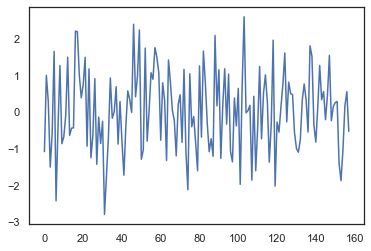

In [12]:
u0["Residual"].plot()

In [13]:
u0.to_pickle("tmp/u0.pkl")

## $h_.(t)$ linear filters

In [14]:
from functools import partial

In [15]:
linear_filters_states = {}

ORDER = 5

for state in results_states.keys():
    u0_ = u0[u0['Updated'].isin(final_data.loc[state, 'Updated'])]
    state_residual = results_states[state][1]
    t = u0_["Updated"].index.astype('float').values.reshape(-1, 1)

    def _yule_walker(u=None, coeff_=None, sigma_=None):
        return np.convolve(coeff_, u, mode="same")

    rho_, sigma_ = sm.regression.yule_walker(state_residual, order=ORDER, method="mle")
    rho_ = np.array(rho_)[::-1]
    linear_filters_states[state] = rho_, partial(
        _yule_walker, u=u0_["Residual"].values, coeff_=tuple(rho_), sigma_=sigma_
    )
        

pickle.dump(linear_filters_states, open('tmp/linear_filters_states.pkl', 'wb'))

---

## Rhos

In [16]:
times = None
for s in final_data.index.unique():
    s_times = set(final_data.loc[s, 'Updated'].unique())
    if times is None:
        times = s_times
    else:
        times = times.intersection(s_times)

In [17]:
u0_ = u0[u0['Updated'].isin(times)]['Residual'].values
T = u0_.shape[0]
t = np.arange(1, T + 1).reshape(-1, 1)

T2 = T - ORDER + 1

rhos = np.zeros((T2*N, T2*N))
for i, (hX, epsX) in enumerate(linear_filters_states.values()):
    for j, (hY, epsY) in enumerate(linear_filters_states.values()):
        convol = np.convolve(hX, hY[::-1], mode="same")
        for t in range(T2):
            data = convol[max(len(convol)//2 - t, 0): min(len(convol), T2 - t + len(convol)//2)]
            jstart = j*T2+max(t - len(convol)//2, 0)
            jend = jstart + len(data)
            rhos[i*T2+t, jstart:jend] = data

In [18]:
# validation
for x in range(N):
    for y in range(N):
        for t in range(T2):
            for s in range(T2):
                assert rhos[x*T2+t, y*T2+s] == rhos[y*T2+s, x*T2+t], \
                f"x={x}, y={y}, t={t}, s={s} => \rho^{{XY}}_{{t,s}} = \rho^{{YX}}_{{s,t}}"
                assert rhos[y*T2+t, x*T2+s] == rhos[x*T2+s, y*T2+t], \
                f"x={x}, y={y}, t={t}, s={s} => \rho^{{YX}}_{{t,s}} = \rho^{{XY}}_{{s,t}}"

In [19]:
np.all(rhos.T == rhos)

True

In [20]:
rhos

array([[1.4199454 , 1.09324416, 0.69261127, ..., 0.        , 0.        ,
        0.        ],
       [1.09324416, 1.4199454 , 1.09324416, ..., 0.        , 0.        ,
        0.        ],
       [0.69261127, 1.09324416, 1.4199454 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.72213021, 0.60635475,
        0.43836552],
       [0.        , 0.        , 0.        , ..., 0.60635475, 0.72213021,
        0.60635475],
       [0.        , 0.        , 0.        , ..., 0.43836552, 0.60635475,
        0.72213021]])

In [21]:
rhos.shape

(2516, 2516)

---

## Marginal Kernels

In [22]:
def prepare_data_for_state(data):
    data = data.copy()
    data.reset_index(inplace=True)
    t = data[["Updated"]]
    y = data[["Updated", "ConfirmedChange"]]
    X = pd.DataFrame({
        "Updated": data["Updated"],
        "state": data["state"].apply(lambda v: list(results_states.keys()).index(v)),
        "index": data["index"],
        "S": data["S"],
        "I": data["I"],
        "HOME": data["HOME"],
        "WORK": data["WORK"],
        "RECREATIONAL": data["RECREATIONAL"],
    }, index=data.index)[[
        "Updated",
        "state",
        "index",
        "S",
        "I",
        "HOME", 
        "WORK", 
        "RECREATIONAL"
    ]]
    return X, y

In [23]:
times = None
for s in final_data.index.unique():
    s_times = set(final_data.loc[s, 'Updated'].unique())
    if times is None:
        times = s_times
    else:
        times = times.intersection(s_times)

In [71]:
# version 2 - repeated kernel

In [31]:
ks = np.zeros_like(rhos)
for s_i, (m_i, r_i) in enumerate(results_states.values()):
    X = m_i.data[0][ORDER-1:]
    k = m_i.kernel(X).numpy()
    ks[s_i*T2:(s_i+1)*T2, s_i*T2:(s_i+1)*T2] = k

In [32]:
GK = ks + rhos

In [33]:
GK

array([[10.80703657, 10.46399971, 10.02693838, ...,  0.        ,
         0.        ,  0.        ],
       [10.46399971, 10.77989093, 10.42141147, ...,  0.        ,
         0.        ,  0.        ],
       [10.02693838, 10.42141147, 10.72287221, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  4.96355963,
         4.91589524,  4.85102957],
       [ 0.        ,  0.        ,  0.        , ...,  4.91589524,
         5.10188029,  5.09215493],
       [ 0.        ,  0.        ,  0.        , ...,  4.85102957,
         5.09215493,  5.31843458]])

In [34]:
GK.shape

(2516, 2516)

In [35]:
Lm = tf.linalg.cholesky(GK)

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

In [ ]:
f = m._model.q_mu
    
q_sqrt = m._model.q_sqrt
full_cov = True

Kmm = kernel(inducing_variable.Z)
Kmm += 1e-6 * tf.eye(inducing_variable.num_inducing, dtype=Kmm.dtype)

Kmn = kernel(inducing_variable.Z, Xnew)

Knn = kernel(Xnew, full_cov=full_cov)

Lm = tf.linalg.cholesky(Kmm)
num_func = tf.shape(f)[-1]  # R
N = tf.shape(Kmn)[-1]

K = tf.rank(Kmn)
perm = tf.concat(
    [
        tf.reshape(tf.range(1, K - 1), [K - 2]),  # leading dims (...)
        tf.reshape(0, [1]),  # [M]
        tf.reshape(K - 1, [1]),
    ],
    0,
)  # [N]
Kmn = tf.transpose(Kmn, perm)  # [..., M, N]

leading_dims = tf.shape(Kmn)[:-2]

# Compute the projection matrix A
Lm = tf.broadcast_to(Lm, tf.concat([leading_dims, tf.shape(Lm)], 0))  # [..., M, M]
A = tf.linalg.triangular_solve(Lm, Kmn, lower=True)  # [..., M, N]

if full_cov:
    fvar = Knn - tf.linalg.matmul(A, A, transpose_a=True)  # [..., N, N]
    cov_shape = tf.concat([leading_dims, [num_func, N, N]], 0)
    fvar = tf.broadcast_to(tf.expand_dims(fvar, -3), cov_shape)  # [..., R, N, N]
else:
    fvar = Knn - tf.reduce_sum(tf.square(A), -2)  # [..., N]
    cov_shape = tf.concat([leading_dims, [num_func, N]], 0)  # [..., R, N]
    fvar = tf.broadcast_to(tf.expand_dims(fvar, -2), cov_shape)  # [..., R, N]

q_sqrt_dims = q_sqrt.shape.ndims
if q_sqrt_dims == 2:
    LTA = A * tf.expand_dims(tf.transpose(q_sqrt), 2)  # [R, M, N]
elif q_sqrt_dims == 3:
    L = tf.linalg.band_part(q_sqrt, -1, 0)  # force lower triangle # [R, M, M]
    L_shape = tf.shape(L)
    L = tf.broadcast_to(L, tf.concat([leading_dims, L_shape], 0))

    shape = tf.concat([leading_dims, [num_func, M, N]], axis=0)
    A_tiled = tf.broadcast_to(tf.expand_dims(A, -3), shape)
    LTA = tf.linalg.matmul(L, A_tiled, transpose_a=True)  # [R, M, N]
else:  # pragma: no cover
    raise ValueError("Bad dimension for q_sqrt: %s" % str(q_sqrt.shape.ndims))

if full_cov:
    fvar = fvar + tf.linalg.matmul(LTA, LTA, transpose_a=True)  # [R, N, N]
else:
    fvar = fvar + tf.reduce_sum(tf.square(LTA), -2)  # [R, N]

if not full_cov:
    fvar = tf.linalg.adjoint(fvar)  # [N, R]

break